In [9]:
from sklearn import svm, metrics
import glob, os.path, re, json
# 텍스트를 읽어 들이고 출현 빈도 조사하기 --- (※1)
def check_freq(fname):
    name = os.path.basename(fname)  # 파일명 가져오기
    lang = re.match(r'^[a-z]{2,}', name).group() # a부터 z까지가 2번 이상 반복 # 나라id 분류 group()
    #  group()은 정규 표현식에 일치하는 것만 가져옴. 파일명에서 a부터 z까지가 2번 이상 나오는 문자를 가져온다.
    with open(fname, "r", encoding="utf-8") as f:
        text = f.read()
    text = text.lower() # 소문자 변환:파일에 있는 모든 내용을 소문자로 읽어 옴.

    #숫자 세기 변수(cnt) 초기화하기
    cnt = [0 for n in range(0, 26)] # 0으로 이루어진 26요소를 가진 리스트 cnt
    code_a = ord("a") # a에 해당하는 아스키값 가지고 오기
    code_z = ord("z") # z에 해당하는 아스키값 가지고 오기

    # 알파벳 출현 횟수 구하기 --- (※2)
    for ch in text:
        n = ord(ch)
        if code_a <= n <= code_z: # a~z 사이에 있을 때
            cnt[n - code_a] += 1 # a가 몇번 나왔는지 b가 몇번 나왔는지 z가지 카운트를 한다.
    # 정규화하기 --- (※3)
    total = sum(cnt)  #리스트에 있는 값 모두 더하기
    freq = list(map(lambda n: n / total, cnt))
    return (freq, lang)
    
# 각 파일 처리하기
def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for fname in file_list:
        r = check_freq(fname)
        freqs.append(r[0])
        labels.append(r[1])
    return {"freqs":freqs, "labels":labels}
data = load_files("./lang/train/*.txt")
test = load_files("./lang/test/*.txt")
# 이후를 대비해서 JSON으로 결과 저장하기
with open("./lang/freq.json", "w", encoding="utf-8") as fp:
    json.dump([data, test], fp)
# 학습하기 --- (※4)
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 예측하기 --- (※5)
predict = clf.predict(test["freqs"])
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(test["labels"], predict)
cl_report = metrics.classification_report(test["labels"], predict)
print("정답률 =", ac_score)
print("리포트 =")
print(cl_report)

ok, {'thin': 6392, 'normal': 5886, 'fat': 7722}


In [ ]:
# c:\> pip install matplotlib numpy pandas

import matplotlib.pyplot as plt
import pandas as pd
import json
# 알파벳 출현 빈도 데이터 읽어 들이기 --- (※1)
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    freq = json.load(fp)
# 언어마다 계산하기 --- (※2)
#print(freq)
lang_dic = {}
for i, lbl in enumerate(freq[0]["labels"]):
    fq = freq[0]["freqs"][i]
    if not (lbl in lang_dic):
        lang_dic[lbl] = fq
        continue
    for idx, v in enumerate(fq):
        lang_dic[lbl][idx] = (lang_dic[lbl][idx] + v) / 2 # 그래프를 그릴 수 있게 언어의 빈도를 집계

# Pandas의 DataFrame에 데이터 넣기 --- (※3)
asclist = [[chr(n) for n in range(97,97+26)]]
df = pd.DataFrame(lang_dic, index=asclist) # index를 a~z까지로 사용
# 그래프 그리기 --- (※4)
plt.style.use('ggplot')
df.plot(kind="bar", subplots=True, ylim=(0,0.15))
plt.savefig("lang-plot.png")


In [ ]:
# 웹 인터페이스 추가하기

from sklearn import svm 
import sklearn.externals 
import joblib
import json
# 각 언어의 출현 빈도 데이터(JSON) 읽어 들이기
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    d = json.load(fp)
    data = d[0]
# 데이터 학습하기
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 학습 데이터 저장하기
joblib.dump(clf, "./lang/freq.pkl")
print("ok")

In [ ]:
#!/usr/bin/env python3
# lang-Webapp.py

# python –m http.server --cgi 8080
# http://127.0.0.1:8080/으로 경로 확인
# 경로에 lang-Webapp.py 저장 
# http://localhost:8080/cgi-bin/lang-Webapp.py

import cgi, os.path
import sklearn.externals 
import joblib
# 학습 데이터 읽어 들이기
pklfile = os.path.dirname(__file__) + "./freq.pkl"
clf = joblib.load(pklfile)
# 텍스트 입력 양식 출력하기
def show_form(text, msg=""):
    print("Content-Type: text/html; charset=utf-8")
    print("")
    print("""
        <html><body><form>
        <textarea name="text" rows="8" cols="40">{0}</textarea>
        <p><input type="submit" value="판정"></p>
        <p>{1}</p>
        </form></body></html>
    """.format(cgi.escape(text), msg))
# 판정하기
def detect_lang(text):
    # 알파벳 출현 빈도 구하기
    text = text.lower() 
    code_a, code_z = (ord("a"), ord("z"))
    cnt = [0 for i in range(26)]
    for ch in text:
        n = ord(ch) - code_a
        if 0 <= n < 26: cnt[n] += 1
    total = sum(cnt)
    if total == 0: return "입력이 없습니다"
    freq = list(map(lambda n: n/total, cnt))
    # 언어 예측하기
    res = clf.predict([freq])
    # 언어 코드를 한국어로 변환하기
    lang_dic = {"en":"영어","fr":"프랑스어",
        "id":"인도네시아어", "tl":"타갈로그어"}
    return lang_dic[res[0]]
# 입력 양식의 값 읽어 들이기
form = cgi.FieldStorage()
text = form.getvalue("text", default="")
msg = ""
if text != "":
    lang = detect_lang(text)
    msg = "판정 결과:" + lang
# 입력 양식 출력
show_form(text, msg)

In [ ]:
import random
# BMI를 계산해서 레이블을 리턴하는 함수
def calc_bmi(h, w):
    bmi = w / (h/100) ** 2      #  <BMI> = <몸무게(kg)> / (<키(m)> * <키(m)>)    
    if bmi < 18.5: return "thin"
    if bmi < 25: return "normal"
    return "fat"
# 출력 파일 준비하기
fp = open("bmi.csv","w",encoding="utf-8")
fp.write("height,weight,label\r\n")
# 무작위로 데이터 생성하기
cnt = {"thin":0, "normal":0, "fat":0}
for i in range(20000):
    h = random.randint(120,200)
    w = random.randint(35, 80)
    label = calc_bmi(h, w)
    cnt[label] += 1
    fp.write("{0},{1},{2}\r\n".format(h, w, label))   # BMI계산에 따른 데이터 저장
fp.close()
print("ok,", cnt)

In [26]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
# 키와 몸무게 데이터 읽어 들이기 --- (※1)
tbl = pd.read_csv("bmi.csv")
# 칼럼(열)을 자르고 정규화하기 --- (※2)
label = tbl["label"]
w = tbl["weight"] / 100 # 최대 100kg라고 가정
h = tbl["height"] / 200 # 최대 200cm라고 가정
wh = pd.concat([w, h], axis=1) # pandas 를 이용해서  for문 없이 데이터 저장
#wh = tbl[["weight","height"]]
print(wh)
# 학습 전용 데이터와 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(wh, label)
# 데이터 학습하기 --- (※4)
clf = svm.SVC()
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

       weight  height
0        0.73   0.790
1        0.40   0.920
2        0.51   0.900
3        0.55   0.935
4        0.64   0.925
...       ...     ...
19995    0.78   0.770
19996    0.59   0.835
19997    0.67   0.800
19998    0.61   0.995
19999    0.76   0.830

[20000 rows x 2 columns]
정답률 = 0.9966
리포트 =
               precision    recall  f1-score   support

         fat       1.00      1.00      1.00      1887
      normal       0.99      1.00      0.99      1485
        thin       1.00      0.99      1.00      1628

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



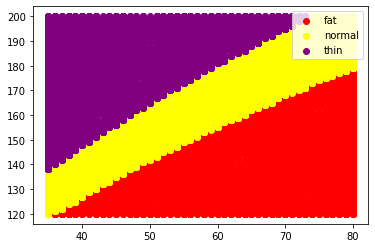

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
# Pandas로 CSV 파일 읽어 들이기
tbl = pd.read_csv("bmi.csv", index_col=2)
# 그래프 그리기 시작
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# 서브 플롯 전용 - 지정한 레이블을 임의의 색으로 칠하기
def scatter(lbl, color):
    b = tbl.loc[lbl]
    ax.scatter(b["weight"],b["height"], c=color, label=lbl)
scatter("fat",    "red")
scatter("normal", "yellow")
scatter("thin",   "purple")
ax.legend() 
plt.savefig("bmi-test.png")
# plt.show()

In [27]:
# 랜덤 포레스트
# 버섯 데이터 셋을 내려 받고 데이터 형식을 확인해 보자.
import urllib.request as req
local= "mushroom.csv"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
req.urlretrieve(url, local)
print("ok")

ok


In [28]:
# 머신러닝을 할 때는 이를 어떻게 숫자로 변환하는지가 문제이다. 
# 일단 각각의 기호가 한 글자라는 것에 주목해서 각 기호를 문자 코드로 변환해서 활용하자.

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 데이터 읽어 들이기--- (※1)
mr = pd.read_csv("mushroom.csv", header=None)
# 데이터 내부의 기호를 숫자로 변환하기--- (※2)
label = []
data = []
attr_list = []
for row_index, row in mr.iterrows():
    label.append(row.iloc[0])
    row_data = []
    for v in row.iloc[1:]:
        row_data.append(ord(v))
    data.append(row_data)
# 학습 전용과 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(data, label)
# 데이터 학습시키기 --- (※4)
clf = RandomForestClassifier()
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

정답률 = 1.0
리포트 =
               precision    recall  f1-score   support

           e       1.00      1.00      1.00      1088
           p       1.00      1.00      1.00       943

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031

